In [0]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Using TensorFlow backend.


In [0]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from keras.optimizers import Adam

In [0]:
import keras
import tensorflow as tf

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d gti-upm/leapgestrecog

100% 2.13G/2.13G [00:19<00:00, 121MB/s] 
100% 2.13G/2.13G [00:19<00:00, 115MB/s]


In [7]:
!unzip leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0013.png  
  inflating: leapgestrecog/leapGestRe

In [0]:
X = []
y = []
for human in os.listdir('leapGestRecog'):
  path = 'leapGestRecog/' + human + '/'
  for gesture in os.listdir(path):
    path = 'leapGestRecog/' + human + '/' + gesture + '/'
    label = gesture[3:]
    for img in os.listdir(path):
      img = cv2.imread(path+img, 0)
      img = cv2.resize(img, (150,150))
      X.append(img)
      y.append(label)

In [0]:
X = np.array(X, dtype='float32')

In [10]:
print(X.shape)

(20000, 150, 150)


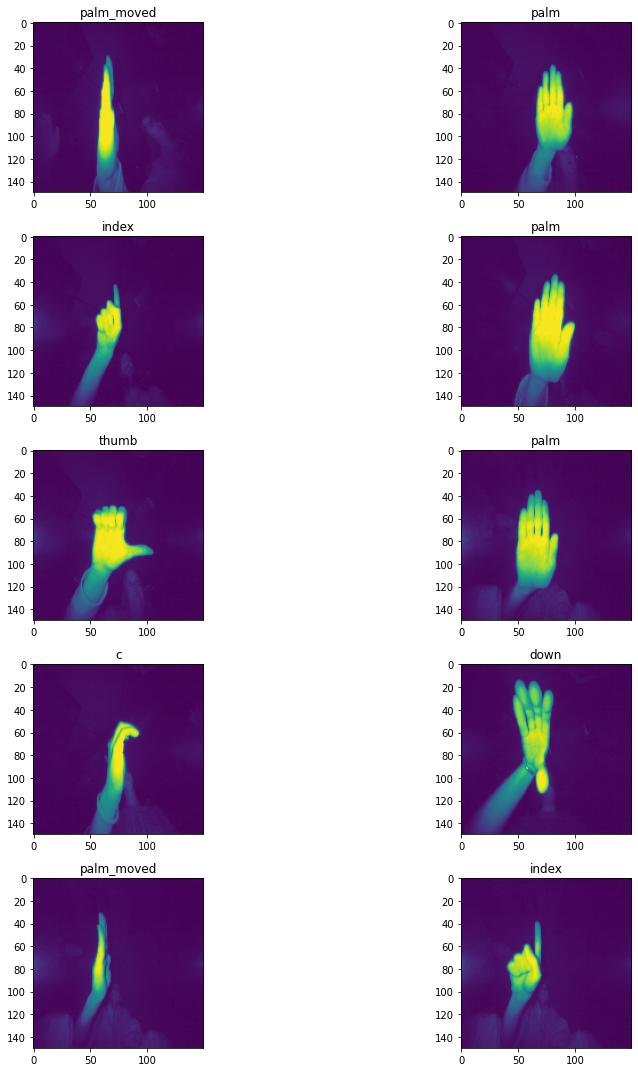

In [11]:
fig, ax = plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
  for j in range(2):
    l = np.random.randint(0, 20000)
    ax[i,j].imshow(X[l])
    ax[i,j].set_title(y[l])
plt.tight_layout()

In [12]:
X = X[:, :, : , np.newaxis]
print(X.shape)

(20000, 150, 150, 1)


In [13]:
print(X.shape)

(20000, 150, 150, 1)


In [0]:
X = X / 255

In [15]:
y[0]

'fist_moved'

In [17]:
le = LabelEncoder()
temp = le.fit_transform(y)
temp
# to_categorical(np.array(y).reshape(-1,1))

array([3, 3, 3, ..., 5, 5, 5])

In [19]:
k = 0
print(y[k], temp[k])

fist_moved 3


In [0]:
z = zip(temp, y)


In [67]:
for _i in set(z):
  l[_i[0]] = _i[1]

l

['c',
 'down',
 'fist',
 'fist_moved',
 'index',
 'l',
 'ok',
 'palm',
 'palm_moved',
 'thumb']

In [0]:
le.inverse_transform(temp)

array(['fist_moved', 'fist_moved', 'fist_moved', ..., 'l', 'l', 'l'],
      dtype='<U10')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)

In [0]:
X_train.shape

(15000, 150, 150, 1)

In [0]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', activation='relu', input_shape=(150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='SAME', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='SAME', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 32)      832       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 18, 96)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 31104)            

In [0]:
batch_size = 128
epochs = 10

In [0]:
checkPoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkPoint,tensorboard,csvlogger,reduce]

In [0]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
History = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10
15000/15000 [==============================] - 348s 23ms/step - loss: 0.3019 - acc: 0.9019
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


15000/15000 [==============================] - 347s 23ms/step - loss: 0.0119 - acc: 0.9977
Epoch 3/10
15000/15000 [==============================] - 350s 23ms/step - loss: 3.8660e-04 - acc: 0.9999
Epoch 4/10
15000/15000 [==============================] - 351s 23ms/step - loss: 4.0895e-05 - acc: 1.0000
Epoch 5/10
15000/15000 [==============================] - 350s 23ms/step - loss: 2.3263e-05 - acc: 1.0000
Epoch 6/10
15000/15000 [==============================] - 351s 23ms/step - loss: 1.6203e-05 - acc: 1.0000
Epoch 7/10
15000/15000 [==============================] - 350s 23ms/step - loss: 1.2031e-05 - acc: 1.0000
Epoch 8/10
15000/15000 [==============================] - 350s 23ms/step - loss: 9.5977e-06 - acc: 1.0000
Epoch 9/10
15000/15000 [==============================] - 353s 24ms/step - loss: 7.6453e-06 - acc: 1.0000
Epoch 10/10
15000/15000 [==============================] - 351s 23ms/step - loss: 6.4183e-06 - acc: 1.0000


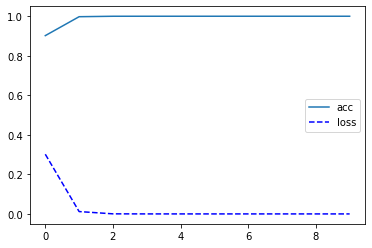

In [0]:
plt.plot(History.history['acc'])
plt.plot(History.history['loss'], 'b--')
plt.legend(['acc', 'loss'])

In [0]:
model.save('./CNN.model')